## Download necessary libraries

In [121]:
!pip install -r requirements.txt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Importing the Necessary Libraries

In [70]:
import pandas as pd
import re
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import nltk
from langdetect import detect, LangDetectException
import contractions
from collections import Counter

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1. Data Preprocessing
#### Loading the Data

In [114]:
# List of NLTK data packages to download
nltk_packages = ['punkt', 'wordnet', 'stopwords']

# Download each package
for package in nltk_packages:
    nltk.download(package)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
with open('DB_reddit.json', 'r', encoding='utf-8') as file:
    reddit = json.load(file)

# Converting the data into a DataFrame
df = pd.DataFrame(reddit)
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,score,date,url,num_comments,comments
0,Not under David Beckhams watch,65534,2023-10-06 17:16:05,https://v.redd.it/0mmzjpgdyisb1,2042,"[Please report rule breaking posts, such as:\n..."
1,David Beckham is not letting this go...,29482,2024-01-02 14:44:45,https://i.redd.it/dowdawvo7y9c1.jpeg,982,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
2,David and Victoria Beckham finally addressing ...,800,2023-10-05 20:46:41,https://v.redd.it/ahnysog1vcsb1,261,[I think if they hadn’t brought this up in a d...
3,Victoria Beckham shares photo of husband David...,2687,2023-12-16 10:45:59,https://i.redd.it/nd35a08lpj6c1.jpeg,298,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
4,Micah Richards on David Beckham,5650,2024-09-19 18:27:36,https://v.redd.it/7o6n7df28qpd1,256,[**Mirrors / Alternative Angles**\n \n\n*I am...


#### Check for Missing Values

In [72]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()

# Display missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
title           0
score           0
date            0
url             0
num_comments    0
comments        0
dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Check for Duplicate Values

In [73]:
duplicates = df.duplicated(subset=['url']).sum()
print(f"Number of duplicate rows: {duplicates}")
df.drop_duplicates(subset=['url'], inplace=True)

Number of duplicate rows: 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Advance Preprocessing

In [74]:
# Regular expression pattern for detecting URLs
url_pattern = r'http\S+|www\S+|https\S+'

# Function to check for URLs in text
def contains_url(text):
    return bool(re.search(url_pattern, text))

# Check for URLs in the 'title' column
df['Title_Contains_URL'] = df['title'].apply(contains_url)

# Check for URLs in the 'comments' column (handling multiple comments in each row)
df['Comments_Contain_URL'] = df['comments'].apply(lambda comments: any(contains_url(comment) for comment in comments))

# Display rows where URLs are found in either title or comments
urls_in_data = df[(df['Title_Contains_URL']) | (df['Comments_Contain_URL'])]

# Display the results
print(f"Total rows with URLs in title: {df['Title_Contains_URL'].sum()}")
print(f"Total rows with URLs in comments: {df['Comments_Contain_URL'].sum()}")

# Optionally, display the rows that contain URLs
if not urls_in_data.empty:
    print("\nRows containing URLs:")
    print(urls_in_data[['title', 'comments']].head())
else:
    print("\nNo URLs found in the dataset.")

Total rows with URLs in title: 0
Total rows with URLs in comments: 81

Rows containing URLs:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   

                                            comments  
0  [Please report rule breaking posts, such as:\n...  
1  [Welcome to r/popculturechat! ☺️\n\nAs a proud...  
2  [I think if they hadn’t brought this up in a d...  
3  [Welcome to r/popculturechat! ☺️\n\nAs a proud...  
4  [**Mirrors / Alternative Angles**\n  \n\n*I am...  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
# Function to clean text (already removing URLs)
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9'\s]", '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Reapply the cleaning function to comments with URLs
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [clean_text(comment) for comment in comments])

# Verify the removal of URLs by checking the updated comments
urls_in_comments_after_removal = df['Cleaned_Comments'].apply(lambda comments: any(re.search(url_pattern, comment) for comment in comments)).sum()
print(f"Total rows with URLs in comments after removal: {urls_in_comments_after_removal}")


# Function to detect if the text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total rows with URLs in comments after removal: 0


In [76]:
# Cleaning and preprocess titles
df['Cleaned_Title'] = df['title'].apply(lambda x: expand_contractions(clean_text(str(x))) if is_english(str(x)) else '')

# Preprocessing each comment within the list
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [expand_contractions(clean_text(comment)) for comment in comments if is_english(comment)])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Stopwords Removal

In [78]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_tokens(tokens):
    # Remove stopwords and lemmatize
    tokens = [word for word in tokens if word not in stop_words]
    # If no tokens are left after stopword removal, return the original tokens
    if not tokens:
        return tokens
    return [lemmatizer.lemmatize(word) for word in tokens]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Tokenization and Lemmatization

In [79]:
# Tokenize and lemmatize the cleaned text
df['Title_Tokens'] = df['Cleaned_Title'].apply(lambda x: process_tokens(word_tokenize(x)))
df['Comments_Tokens'] = df['Cleaned_Comments'].apply(lambda comments: [process_tokens(word_tokenize(comment)) for comment in comments])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [80]:
# Display the processed data
processed_columns = ['title', 'Cleaned_Title', 'Title_Tokens', 'comments', 'Cleaned_Comments', 'Comments_Tokens']
print("\nProcessed Data:")
print(df[processed_columns].head(10))


Processed Data:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   
5                                Young David Beckham   
6                         Thoughts on David Beckham?   
7  david beckham: then vs now – is it just me or ...   
8                          David Beckham is autistic   
9  David and Victoria Beckham recreate their wedd...   

                                       Cleaned_Title  \
0                                                      
1               david beckham is not letting this go   
2  david and victoria beckham finally addressing ...   
3  victoria beckham shares photo of husband david...   
4                    micah richards on david beckham   
5                             

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Term Frequency

In [81]:
lemmatizer = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))

def process_text(text, lemmatizer, stopwords_set):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_set]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

term_freq_counter = Counter()

# Processing each row in the DataFrame and updating term frequency counts
for _, row in df.iterrows():
    tokens_title = process_text(row['Cleaned_Title'], lemmatizer, stopwords_set)
    tokens_comments = [word for comment in row['Cleaned_Comments'] for word in process_text(comment, lemmatizer, stopwords_set)]

    # Updating term frequency counts
    term_freq_counter.update(tokens_title)
    term_freq_counter.update(tokens_comments)

# Displaying the most common terms
freq_num = 50
print(f"Top {freq_num} most common terms:")
for term, count in term_freq_counter.most_common(freq_num):
    print(f"{term}: {count}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 50 most common terms:
like: 2629
would: 1827
people: 1740
think: 1395
one: 1358
know: 1190
look: 1126
class: 1110
get: 1089
beckham: 1074
time: 1001
really: 912
even: 911
david: 853
good: 840
also: 823
make: 805
year: 800
thing: 780
much: 771
love: 718
still: 702
way: 697
's: 680
never: 671
could: 669
see: 623
working: 618
well: 613
going: 605
money: 598
say: 577
always: 564
lol: 562
got: 559
go: 552
lot: 542
want: 530
right: 517
victoria: 511
work: 510
someone: 507
mean: 505
u: 504
woman: 467
said: 460
man: 458
back: 455
made: 447
though: 444


# WordCloud of Sentiment Heavy Words and Entities

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


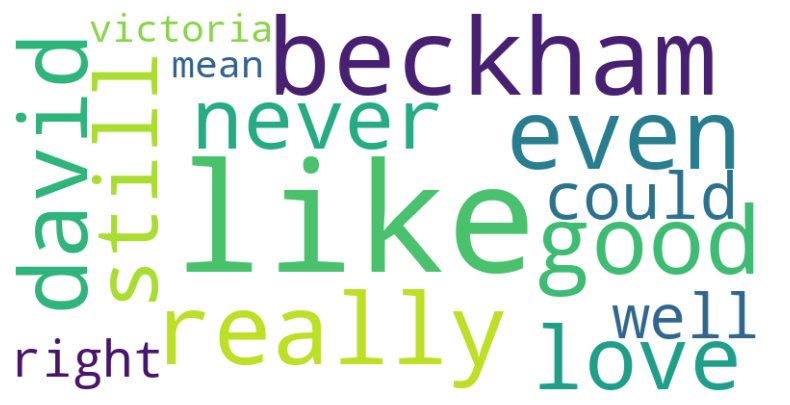

In [82]:
# Visualizing the sentiment heavy words and entities by WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Dictionary with sentiment heavy words and entities and their frequencies as values
words_freq = {
    "like": 2627,
    "beckham": 1077,
    "really": 912,
    "even": 911,
    "good": 844,
    "david": 848,
    "love": 720,
    "still": 702,
    "never": 671,
    "could": 669,
    "well": 614,
    "right": 517,
    "victoria": 512,
    "mean": 504
}


# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_freq)

# Plotting the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hiding axes
plt.show()


# Bar Chart of Sentiment Heavy Words and Entities with their frequencies

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


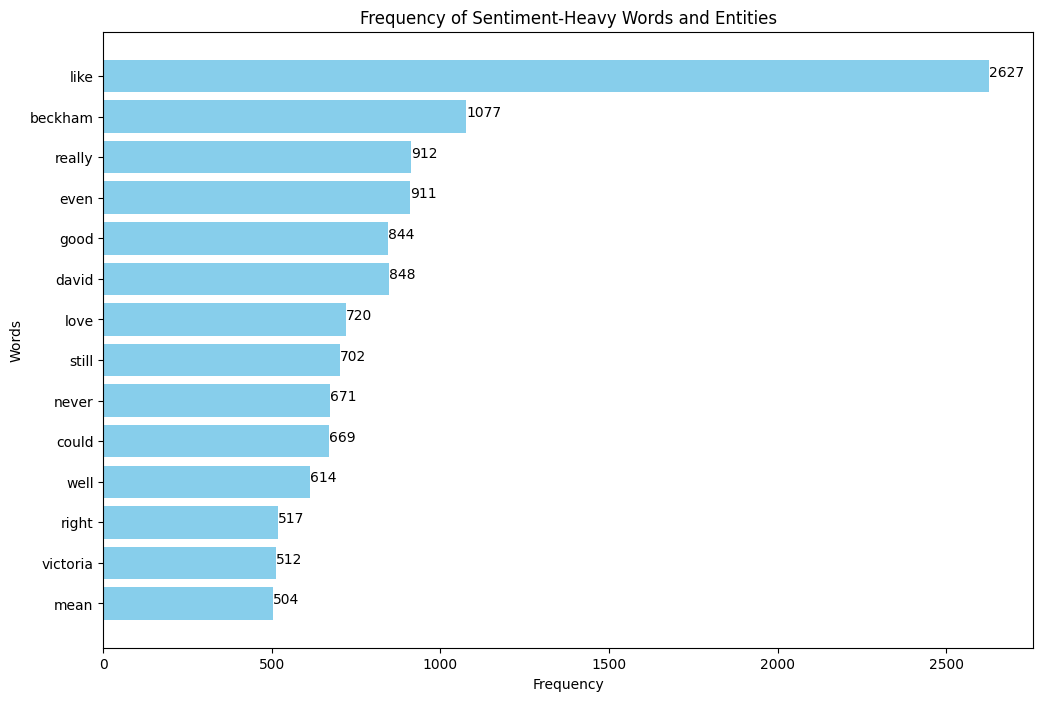

In [83]:
# Visualizing the sentiment heavy words and entities and their frequencies as values

# List of words and their frequencies
words = [
    'like', 'beckham', 'really', 'even', 'good', 'david', 'love',
    'still', 'never', 'could', 'well', 'right', 'victoria', 'mean'
]

frequencies = [
    2627, 1077, 912, 911, 844, 848, 720,
    702, 671, 669, 614, 517, 512, 504
]


# Plotting the bar chart
plt.figure(figsize=(12,8))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency of Sentiment-Heavy Words and Entities')
plt.gca().invert_yaxis()  # Inverting y axis to have the most frequent word on top

# Adding frequencies next to the bars  # Adding frequencies next to the bar
for index, value in enumerate(frequencies):
    plt.text(value, index, str(value))
plt.show()


# Tfidf Vectorization

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function for Pre-processing text by removing numbers
def preprocess_text(text):
    return re.sub(r'\d+', '', text)

# loading data from json file
with open('DB_reddit.json', 'r', encoding='utf-8') as f:
    posts_data = json.load(f)

    comments = []
    for post in posts_data:
        for comment in post['comments']:
            preprocessed_comment = preprocess_text(comment)  # Preprocessing the comments
            comments.append(preprocessed_comment)  # Storing preprocessed comments

# Converting the comments into a dataframe
df = pd.DataFrame(comments, columns=['Cleaned_Comments'])

# Checking the dataframe
print("DataFrame preview (first 5 rows):")
print(df.head())

# Adjusting the token pattern to exclude purely numerical tokens and refining the ngram range
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',  # Excludes purely numeric tokens and requires at least three characters
    ngram_range=(1,2),  #unigram and bi-gram
    min_df=10,  # Increase min_df to reduce features that appear rarely
    max_df=0.5 # Lower max_df to exclude terms that are too common

)

# Fitting and transforming the comments into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Comments']).toarray()

# Converting to DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DataFrame preview (first 5 rows):
                                    Cleaned_Comments
0  Please report rule breaking posts, such as:\n\...
1                         David ain't fuckin' around
2  David Beckham actually grew up working class s...
3           Well, she wasn’t Poor Spice for a reason
4  David Beckham is pissed because he is actually...
   ability  able  absolute  absolutely     abuse  accent   account  act  \
0      0.0   0.0       0.0         0.0  0.312261     0.0  0.152936  0.0   
1      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
2      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
3      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
4      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   

   acting   action  ...  year old  years  years ago  yep  yes  young  younger  \
0     0.0  0.13697  ...       0.0    0.0        0.0  0.0  0.0    0.0      0.0   
1     0.0  0.00000  ...       0.0  

# Vader Sentiment Analysis

In [85]:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initializing VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis with error handling
def analyze_sentiment(text):
    if text:  # Checking if text is not empty or None
        try:
            sentiment = analyzer.polarity_scores(text)
            return sentiment['compound']  # Compund score represents overall sentiment
        except Exception as e:
            print(f"Error analyzing sentiment: {e}")
            return None  # Return None if there's an error
    else:
        return None  # Return None for empty or None text

# Applying sentiment analysis
df['sentiment_score'] = df['Cleaned_Comments'].apply(analyze_sentiment)

# Categorize sentiment based on the score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Printing results
print("DataFrame with sentiment scores and categories (first 5 rows):")
print(df[['Cleaned_Comments', 'sentiment_score', 'sentiment_category']].head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DataFrame with sentiment scores and categories (first 5 rows):
                                    Cleaned_Comments  sentiment_score  \
0  Please report rule breaking posts, such as:\n\...          -0.9505   
1                         David ain't fuckin' around           0.0000   
2  David Beckham actually grew up working class s...           0.0000   
3           Well, she wasn’t Poor Spice for a reason          -0.2500   
4  David Beckham is pissed because he is actually...          -0.6369   

  sentiment_category  
0           negative  
1            neutral  
2            neutral  
3           negative  
4           negative  


# Visualizing sentiment score distribution by histogram and density plot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


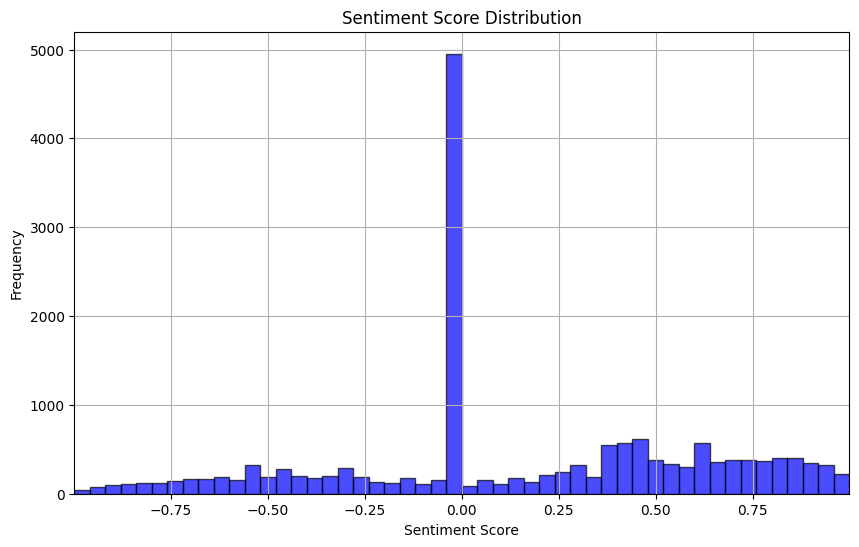

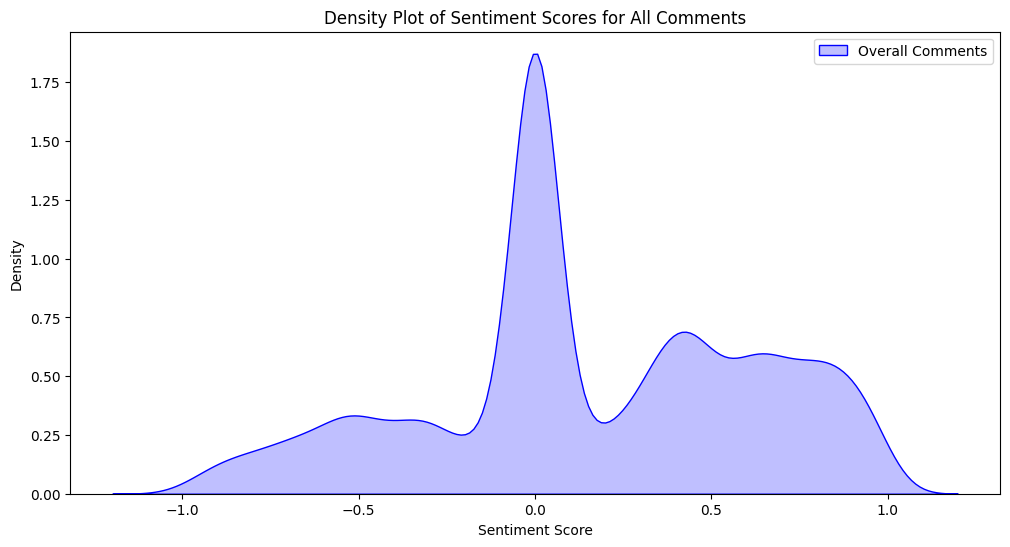

In [86]:
#Visualizing sentiment score distribution by histogram and density plot

num_bins = 50  # Number of bins

# Plotting sentiment score distribution
plt.figure(figsize=(10,6))
plt.hist(df['sentiment_score'], bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
plt.grid(True)   # For better readability

# Setting plot titles and labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')

# Setting x and y limits
plt.xlim(df['sentiment_score'].min(), df['sentiment_score'].max())
plt.ylim(0, plt.ylim()[1])  # Ensuring y axis starts from 0 and is correclty scaled

plt.show()


# Plotting density of sentiment scores for all comments
import seaborn as sns
plt.figure(figsize=(12,6))
sns.kdeplot(df['sentiment_score'], fill=True, color='blue', label='Overall Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores for All Comments')
plt.legend()
plt.show()

# Word Cloud for overall comments

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


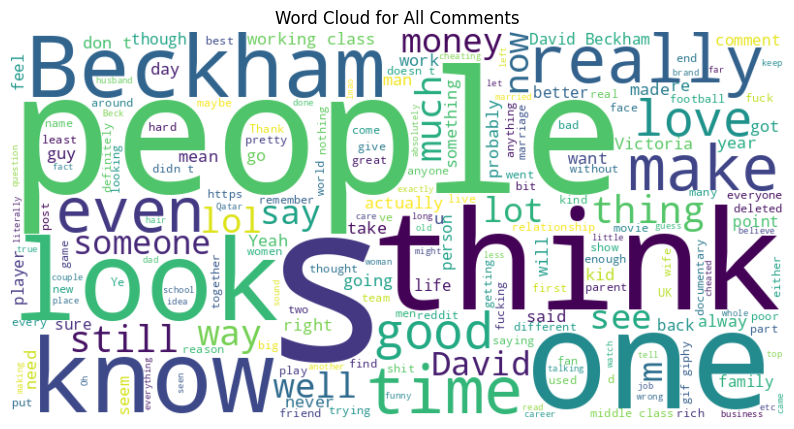

In [87]:
# Word Cloud for overall comments

from wordcloud import WordCloud, STOPWORDS
all_comments = ' '.join(df['Cleaned_Comments'])

# Generating word cloud with custom settings
wordcloud = WordCloud(
    width=800, height=400, background_color='white',
    stopwords=set(STOPWORDS), max_words=200, colormap='viridis'
).generate(all_comments)

# Displaying the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels and ticks
plt.title('Word Cloud for All Comments')
plt.show()


## Topic Modelling

### Plotting coherence term plot to determine optimal number of topics

In [102]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import numpy as np
# Extracting 'Cleaned_Comments' from the DataFrame
lPosts = df['Cleaned_Comments'].tolist()
data = [post.split() for post in lPosts]

# Create Dictionary and Corpus (this part remains the same)
id2word = corpora.Dictionary(data)
texts = data
corpus = [id2word.doc2bow(text) for text in texts]

# def compute_coherence_for_model(params):
#     """Compute coherence for a single model"""
#     num_topics, dictionary, corpus, texts = params
#     model = gensim.models.LdaModel(
#         corpus=corpus,
#         id2word=dictionary,
#         num_topics=num_topics,
#         random_state=100,
#         update_every=1,
#         chunksize=100,
#         passes=10,
#         alpha='auto',
#         per_word_topics=True
#     )
#     coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#     return coherence_model.get_coherence()

# def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
#     """Compute coherence values for multiple models in parallel"""
#     pool = Pool(processes=cpu_count())
#     coherence_values = pool.map(
#         compute_coherence_for_model,
#         [(num_topics, dictionary, corpus, texts) for num_topics in range(start, limit, step)]
#     )
#     pool.close()
#     pool.join()
#     return coherence_values

# # Set parameters
# start, limit, step = 2, 40, 6

# # Compute coherence values
# coherence_values = compute_coherence_values(id2word, corpus, texts, start, limit, step)

# # Plot results
# x = range(start, limit, step)
# plt.figure(figsize=(12, 6))
# plt.plot(x, coherence_values, 'bo-')
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.title("Topic Coherence Scores by Number of Topics")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Find optimal number of topics
# optimal_num_topics = x[np.argmax(coherence_values)]
# print(f'Optimal number of topics: {optimal_num_topics}')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
topicNum = 5
wordNumToDisplay = 10
featureNum = 1500

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Performs counting via CountVectorizer and then apply the LDA model.

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lPosts)
tfFeatureNames = tfVectorizer.get_feature_names_out()

ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visualising topics

In [92]:
# Define the display_topics function
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        for i in topic.argsort()[:-num_top_words - 1:-1]:
            print(f"{feature_names[i]} ({topic[i]:.4f})")
        print()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Diplays discovered topics.

In [93]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
think (958.8335)
just (929.6367)
don (856.8952)
good (834.5569)
like (805.0228)
people (749.0488)
time (625.6380)
way (469.6731)
know (465.4545)
ve (427.3000)

Topic 1:
class (895.7883)
people (825.2954)
like (583.5317)
working (523.6070)
money (503.0630)
just (485.0606)
victoria (442.5476)
work (407.3262)
better (385.1450)
rich (348.9155)

Topic 2:
beckham (1189.5901)
david (857.3693)
like (759.1052)
love (667.6989)
just (505.7643)
going (447.3011)
probably (426.7718)
man (400.7197)
lol (395.1501)
yeah (377.4041)

Topic 3:
look (637.0761)
https (626.0928)
looks (572.4794)
like (329.5406)
com (322.9473)
www (257.9946)
reddit (257.2449)
comment (233.6893)
gif (228.1196)
watch (210.5908)

Topic 4:
didn (682.4428)
got (528.9416)
said (463.2560)
did (411.4677)
years (404.2517)
thought (338.6955)
great (303.2425)
deleted (260.3174)
year (246.2788)
like (238.9982)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne') # Use lda_model for prepare
pyLDAvis.display(panel)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Network Analysis and Community Detection

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Documents related to Topic 0:

Document 1: The way that she gives that smug smile at the end makes the whole thing seem even more performative

Document 2:  years of marriage, yes you start calling each other out for their bullshit.

Document 3: Oof. He wasn’t fucking around. This ain’t the first time he’s heard some bullshit come out her mouth.

Document 4: Is he a nice dude in general? I don't follow what he does so I'm not sure, but this interaction is speaking very positively of him. I don't know how do I feel about calling out your celebrity wife on TV though. They definitely had a fight about it afterwards

Document 5: It's called teasing and they can do that because they care about each other, just like Zelensky talking about how he misses his wife making him breakfast.  
They know they are on camera.    
They are doing this on purpose for the audience because they know how well people eat this kind of either/or Good/Bad rhetoric up.

Document 6: They try so hard to be some magi

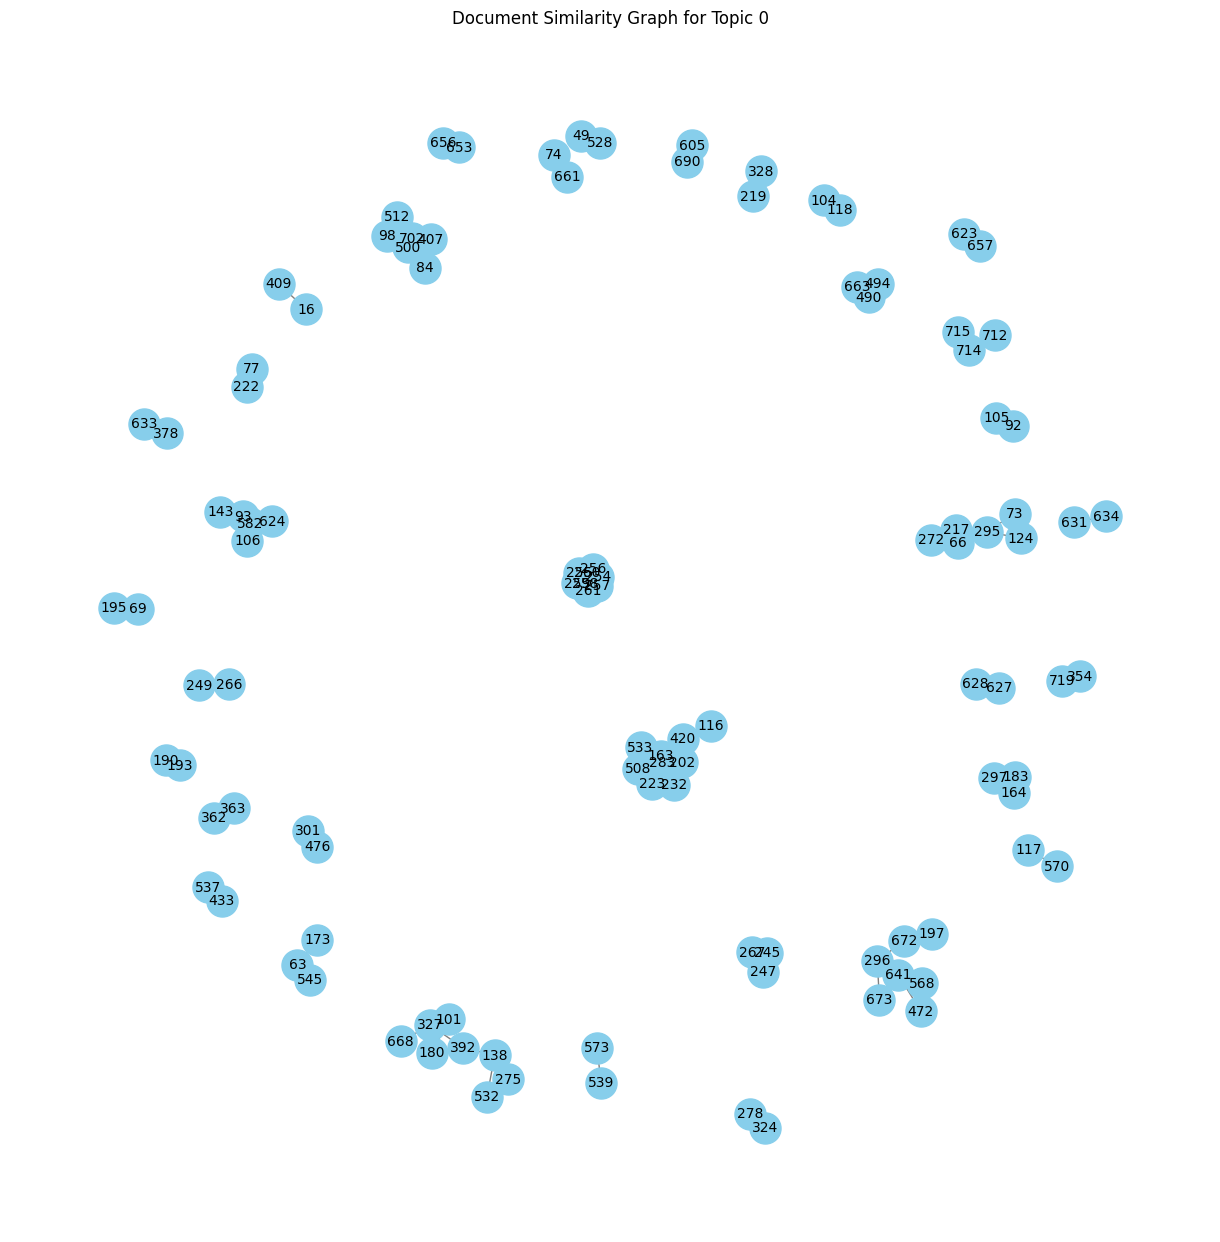

Documents related to Topic 1:

Document 1: David Beckham actually grew up working class so he knows what it means to be working class.

Document 2: its not our choice to be born poor or rich but lying about it is fucked up

Document 3: Why so rich people have this impulse to show they come from humble beginnings or that they worked hard to make their way to the top…  if you were born rich, so what?

Document 4: He's not letting her get away with that shit 😆

Document 5: Rich people always have this sort of hard done by victim complex

“Working class” come off it ya Posh fuck

Document 6: Becks grew up working class, so maybe she's stealing his stories for clout.

Document 7: You know what, I respect this dynamic in a marriage. Calling each others white lies out and Victoria being full aware she is fibbing but not getting overly offended. Must be a British thing. They get it

Document 8: He took that shit personal.

There's only one person that grew up working class in that house and it

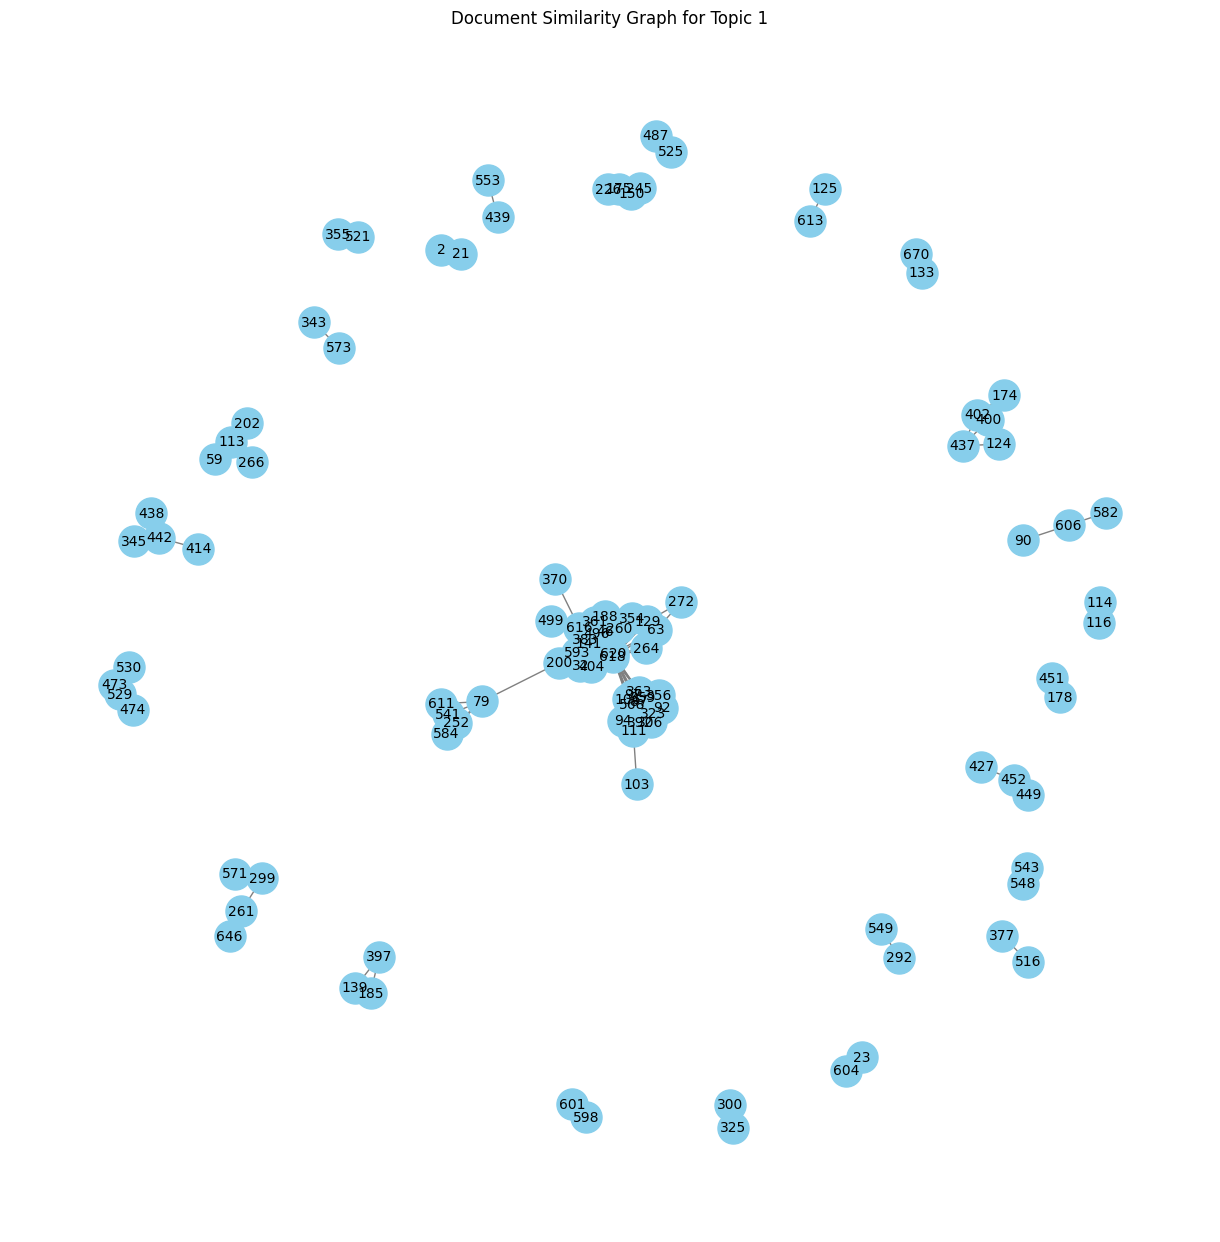

Documents related to Topic 2:

Document 1: David ain't fuckin' around

Document 2: Quick google search tells me her old man was a sparky, of course he drove a roller.. probably wiped his arse on fifties and lit his cigars with scores.

Document 3: Why isn't everyone else thinking this is some scripted humor? Am I watching this differently??

Document 4: I have a newfound respect for David Beckham

Document 5: Haha.. I love David Beckham

Document 6: Wasn’t she “posh spice” of the spice girls? lmfao

Document 7: I actually really appreciate David calling her out on this.

Document 8: The way he acts tells me that Spice-a-roni tends to embellish quite frequently!!!

Document 9: Beck comes off so good on this series. He’s honest and down to earth. He’s a national treasure.

Document 10: say what you want about her but she is really adore him ! i saw epi  and  and you can tell why they are still married ! she literally in love with him

Document 11: She ruined the world cup for us , so str

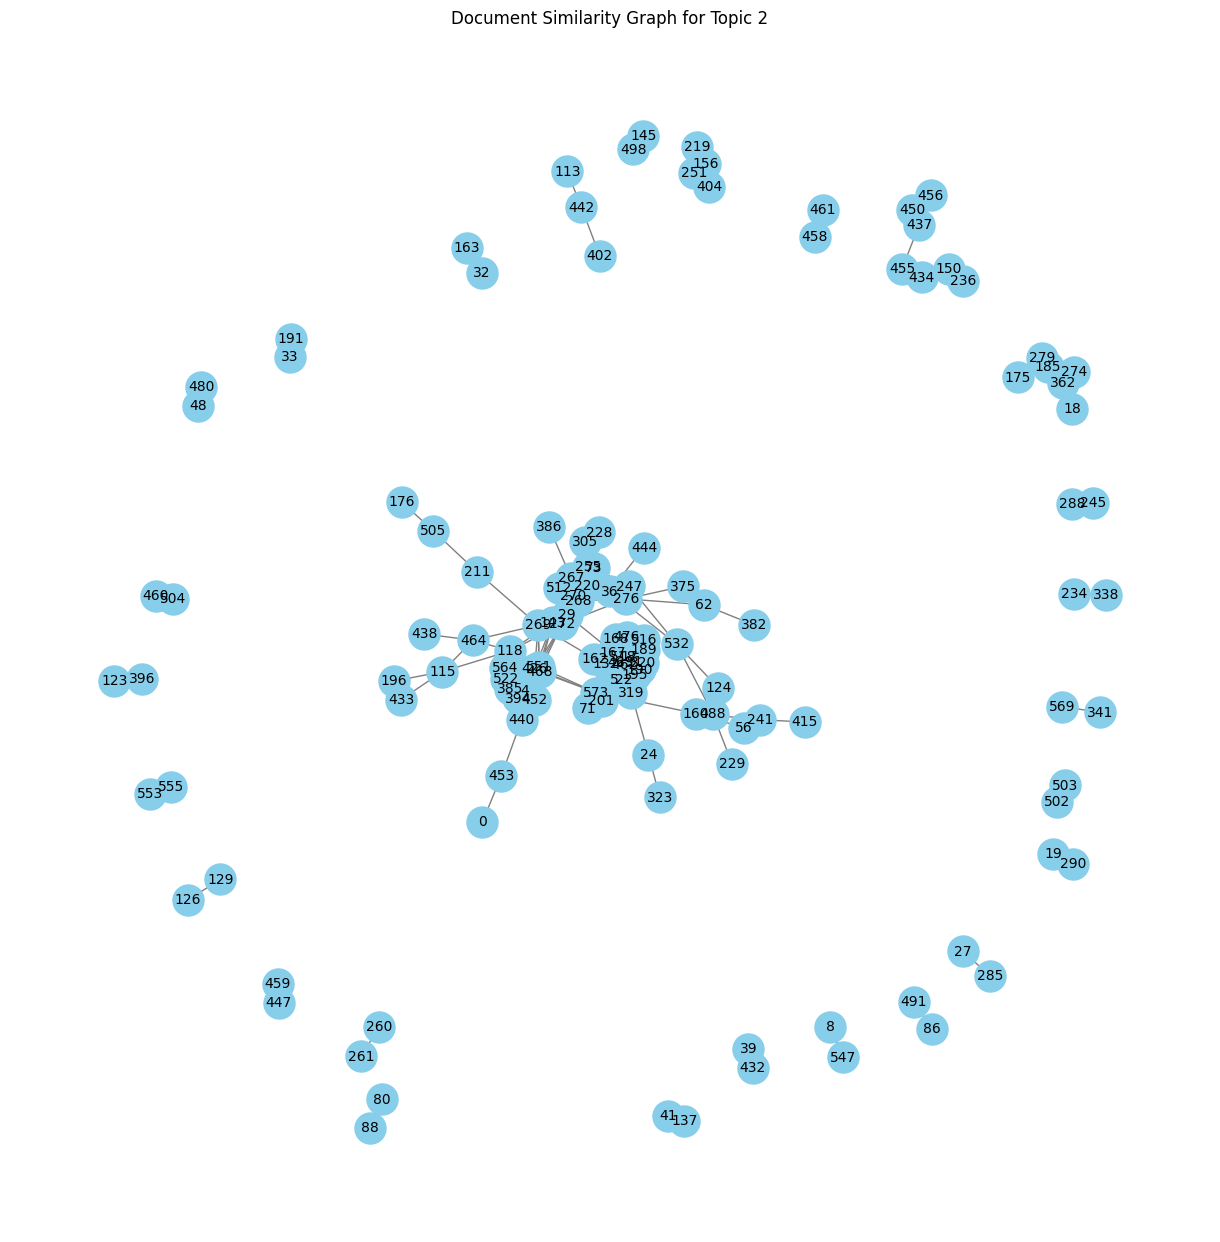

Documents related to Topic 3:

Document 1: Please report rule breaking posts, such as:

 - politics of any kind
 - discrimination, hate, or prejudice based on protected grounds
 - where the "funny" is mostly cringe, freakout, reaction, or cute
 - violence, injury, or animal abuse
 - pornography or sexually explicit material
 - threatening, advocating, wishing, or glorifying death or violence
 - contains graphic language or obvious mature themes, and is not marked NSFW

Please do not report content you simply don't like or disagree with. Abuse of the report button will be reported to Reddit and you may face account suspension.

###[Video Download](https://redditsave.com/info?url=https://v.redd.it/mmzjpgdyisb)

** All other video downloading comment tags will be removed **


*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/funnyvideos) if you have any questions or concerns.*

Document 2: This is gold lmao.

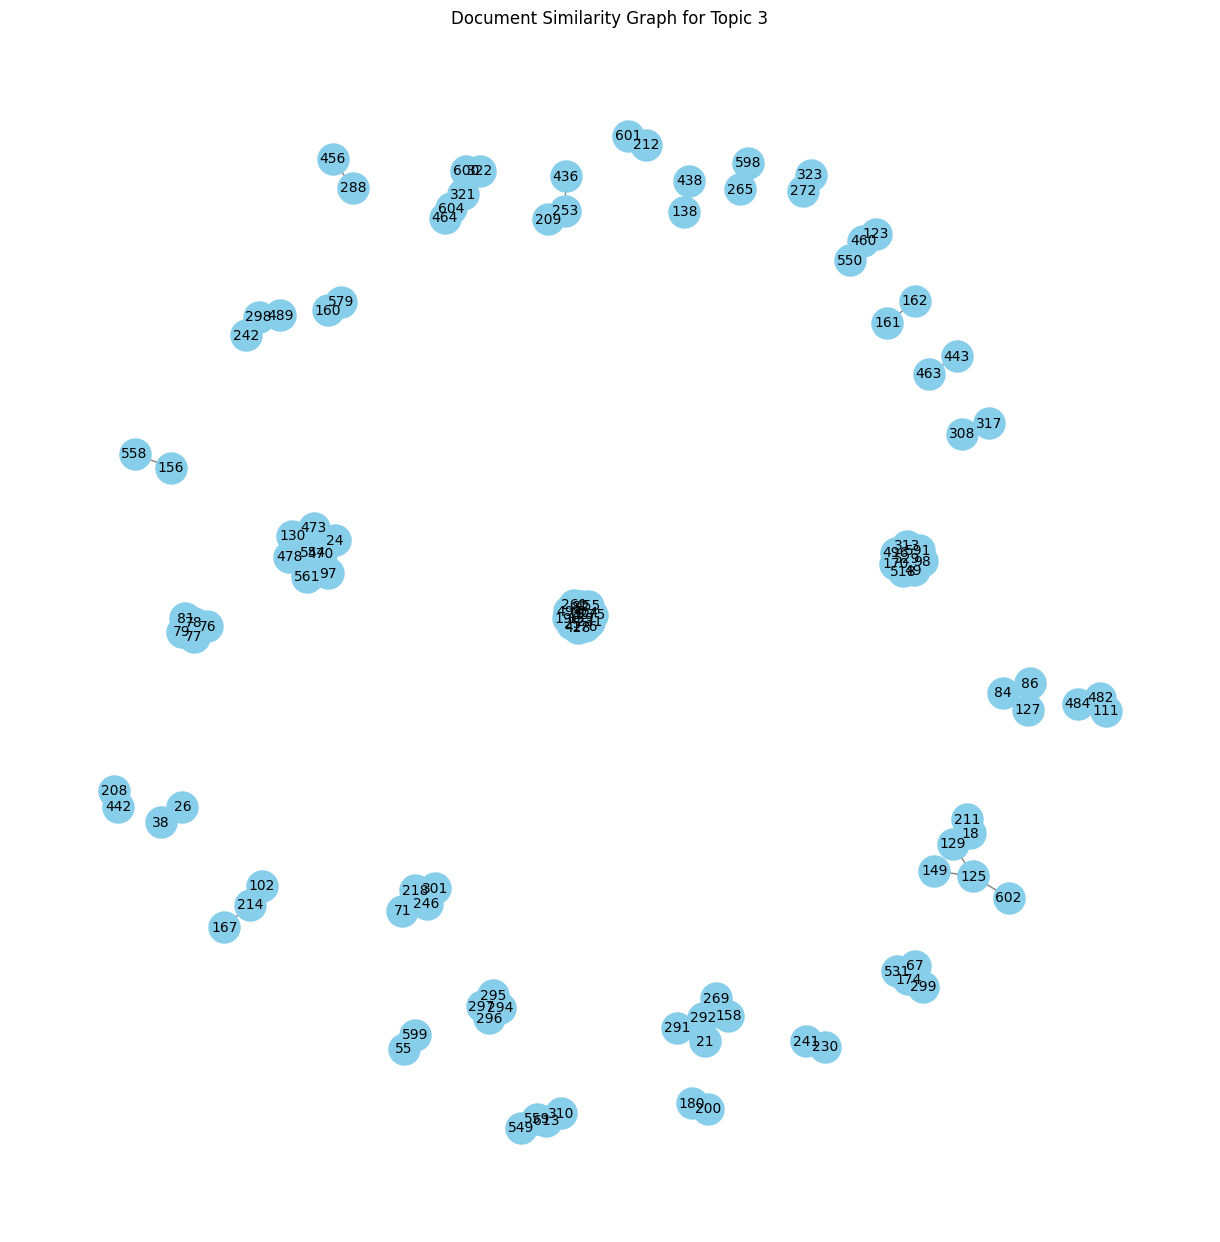

Documents related to Topic 4:

Document 1: I knew a rich girl in middle school who was claiming to be provided because for some reason it was cool to be poor. 
I first explained how her shoes that she was wearing alone were more valuable than my entire wardrobe, which somehow she didn't understand. So I got annoyed and said "oh, you said you are poor, I thought I heard you say your daddy drives a porche."
She said she's poor, her parents are rich... ish years ago, I'm still sure she's an idiot to today

Document 2: Oops... he threw her under several double-decker buses...

Document 3: Great ad

Document 4: I know so many "well off people" who are extremely humble about it and down to Earth. Treat you like you mean the world to them and are grateful for every little thing. And are well aware of their luck and blessings.  


So yea youre entirely spot on. Understand what you have and dont lie about it.

Document 5: I've seen the first episode and I thought it was great. Very surprised at

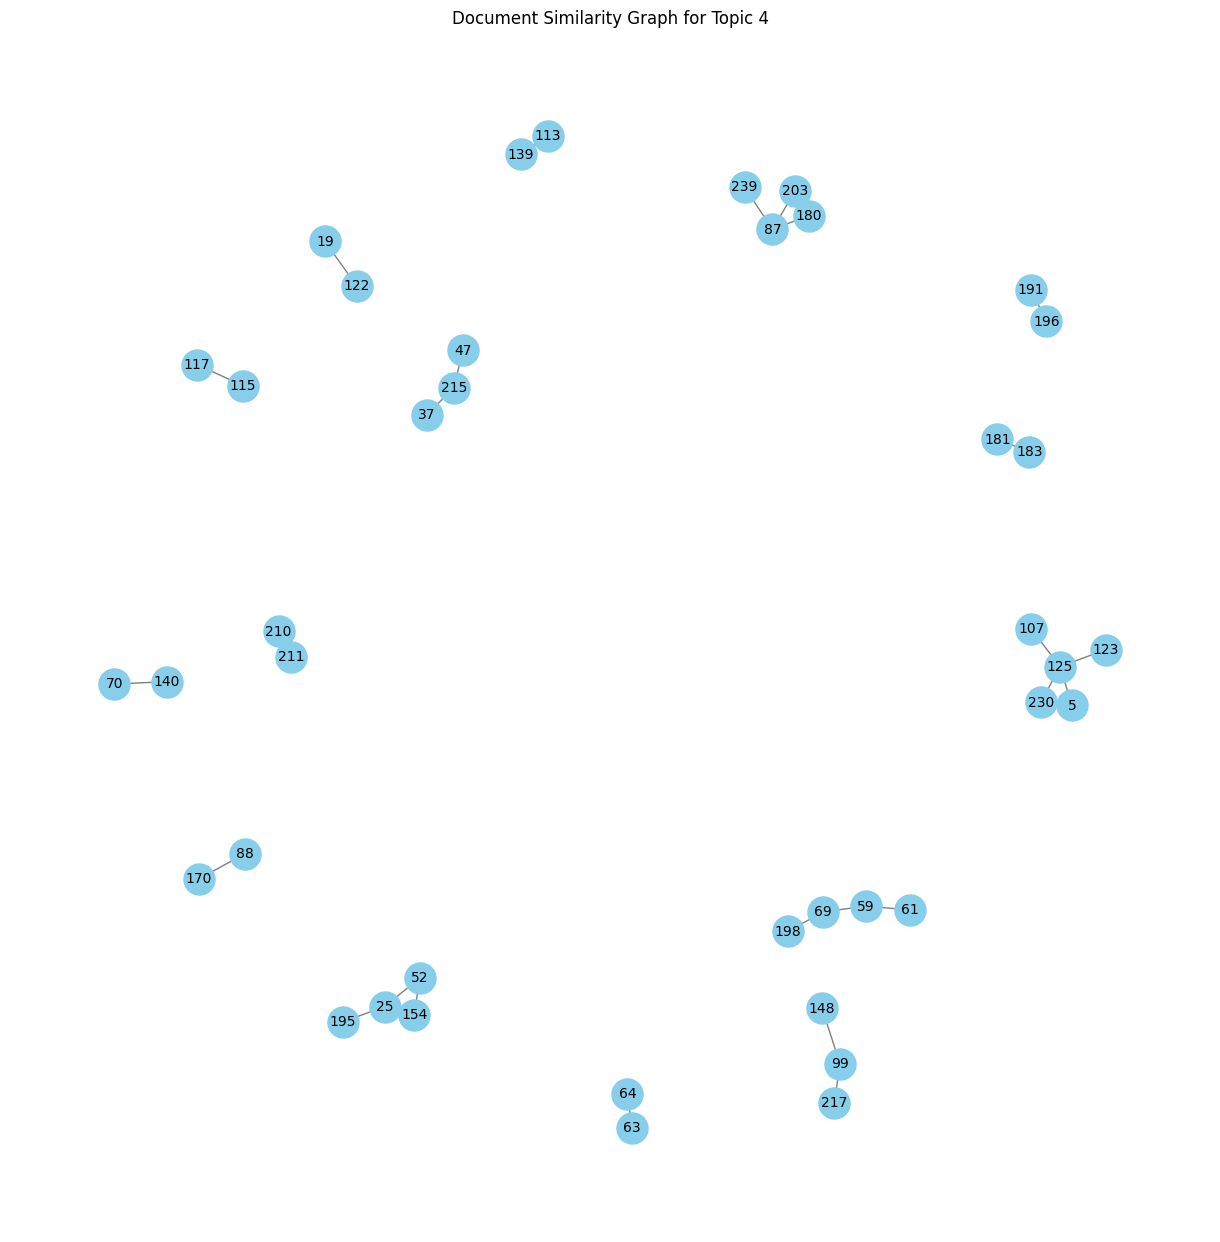

In [111]:
import networkx as nx
from networkx.algorithms import community
# Define a threshold for considering a document as related to a topic
threshold = 0.7  # Example value, adjust as needed

# Iterate over each topic
for topic_idx in range(ldaModel.n_components): # Use n_components instead of num_topics
    # Extract documents related to the current topic
    related_docs_indices = np.where(doc_topic_dist[:, topic_idx] > threshold)[0]
    related_docs = [lPosts[i] for i in related_docs_indices]

    # Print the related documents
    print(f"Documents related to Topic {topic_idx}:\n")
    for idx, doc in enumerate(related_docs):
        print(f"Document {idx + 1}: {doc}\n")

    # Perform community analysis
    # Step 1: Vectorize the related documents using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(related_docs)

    # Step 2: Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)

    # Step 3: Create a graph from the cosine similarity matrix
    G = nx.Graph()
    for i in range(len(related_docs)):
        for j in range(i + 1, len(related_docs)):
            if cosine_sim_matrix[i, j] > 0.5:  # Example threshold, adjust as needed
                G.add_edge(i, j, weight=cosine_sim_matrix[i, j])

# Step 4: Detect communities using the Girvan-Newman method
    communities_generator = community.girvan_newman(G) # Call girvan_newman directly from the community module
    top_level_communities = next(communities_generator)
    sorted_communities = sorted(map(sorted, top_level_communities))

# Print the communities
    print(f"Communities for Topic {topic_idx}:\n")
    for idx, community_list in enumerate(sorted_communities): # Renamed 'community' to 'community_list' to avoid name conflict
        print(f"Community {idx + 1}:")
        for doc_idx in community_list:
            print(f"Document {doc_idx + 1}: {related_docs[doc_idx]}")
        print("="*80)  # Separator between communities

    # Export the graph to a GEXF file for Gephi
    nx.write_gexf(G, f"reddit_document_similarity_graph_topic_{topic_idx}.gexf")

    # Visualize the graph and save it as an image
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
    plt.title(f"Document Similarity Graph for Topic {topic_idx}")
    plt.savefig(f"reddit_document_similarity_graph_topic_{topic_idx}.png")  # Save the graph as an image
    plt.show()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain  # For Louvain community detection

# Assuming df is your DataFrame with columns 'comments' containing lists of comments
batch_size = 1000  # You can adjust this batch size based on your system memory
num_batches = len(df) // batch_size + 1

# Initialize an empty graph
G = nx.Graph()

In [ ]:
# Step 1: Batch processing to build the graph
for batch_num in range(num_batches):
    batch_df = df[batch_num * batch_size: (batch_num + 1) * batch_size]

    # Process each batch of comments
    for idx, row in batch_df.iterrows():
        comments = row['Cleaned_Comments']  # List of comments for each post
        # Add edges between commenters
        for i in range(len(comments)):
            for j in range(i+1, len(comments)):
                G.add_edge(f"commenter_{i}", f"commenter_{j}")

    print(f"Processed batch {batch_num + 1} out of {num_batches}")

In [ ]:
#check the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Total number of nodes: {num_nodes}")
print(f"Total number of edges: {num_edges}")

In [ ]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)
print("Degree Centrality calculated.")

In [ ]:
# Sort and display top 5 nodes by Degree Centrality
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by Degree Centrality:")
for node, centrality in top_degree:
    print(f"Node: {node}, Degree Centrality: {centrality}")


In [ ]:
import random

# Define the top 5 commenters
top_commenters = ['commenter_0', 'commenter_1', 'commenter_2', 'commenter_3', 'commenter_4']

# Extract only a sample of neighbors (e.g., 10 random neighbors for each top commenter)
subgraph_nodes = set()
for node in top_commenters:
    neighbors = list(G.neighbors(node))
    # Take only a random sample of neighbors (adjust sample size based on performance)
    sampled_neighbors = random.sample(neighbors, min(10, len(neighbors)))
    subgraph_nodes.update(sampled_neighbors)



In [ ]:
# Add the top commenters themselves to the subgraph
subgraph_nodes.update(top_commenters)

# Create the smaller subgraph
subgraph = G.subgraph(subgraph_nodes)
print(f"Subgraph now contains {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")


In [ ]:
# Calculate Degree Centrality on the subgraph
degree_centrality_subgraph = nx.degree_centrality(subgraph)
print("Degree Centrality calculated on subgraph.")


In [ ]:
# Calculate Betweenness Centrality on the subgraph
betweenness_centrality_subgraph = nx.betweenness_centrality(subgraph)
print("Betweenness Centrality calculated on subgraph.")


In [ ]:
# Calculate Clustering Coefficient on the subgraph
clustering_coefficient_subgraph = nx.clustering(subgraph)
print("Clustering Coefficient calculated on subgraph.")


In [ ]:
# Display results for the top 5 nodes
top_commenters = ['commenter_0', 'commenter_1', 'commenter_2', 'commenter_3', 'commenter_4']

for node in top_commenters:
    print(f"\nNode: {node}")
    print(f" - Degree Centrality: {degree_centrality_subgraph.get(node, 'Not found')}")
    print(f" - Betweenness Centrality: {betweenness_centrality_subgraph.get(node, 'Not found')}")
    print(f" - Clustering Coefficient: {clustering_coefficient_subgraph.get(node, 'Not found')}")


In [ ]:
# Apply Louvain community detection on the subgraph
partition = community_louvain.best_partition(subgraph)

# Display the community each top commenter belongs to
print("Louvain community detection results for top 5 nodes:")
for node in top_commenters:
    print(f"Node: {node}, Community: {partition.get(node, 'Not found')}")

# Number of communities detected
num_communities = len(set(partition.values()))
print(f"\nTotal number of communities detected: {num_communities}")


In [ ]:
import random
import networkx as nx

# Number of nodes to extract
num_nodes = 1000

# Convert the nodes to a list and then randomly sample 1000 nodes from the original graph G
sampled_nodes = random.sample(list(G.nodes()), num_nodes)

# Create a subgraph with the sampled nodes
subgraph = G.subgraph(sampled_nodes)

# Display the size of the subgraph
print(f"Subgraph contains {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")

In [ ]:

# Export the subgraph to GEXF format for Gephi
nx.write_gexf(subgraph, "subgraph_1000_nodes.gexf")
print("Subgraph exported to 'subgraph_1000_nodes.gexf'")